### **0. Import Statements**

In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### **1. Load the Processed Data**

In [3]:
final_joke_dataset = r'..\..\data\processed\output_final_joke_dataset_expanded.json'

# Load data in chunks to prevent memory overload
chunk_size = 5000 
df_chunks = []

with tqdm(total=84824, desc="Loading JSON data") as pbar:
    for chunk in pd.read_json(final_joke_dataset, lines=True, chunksize=chunk_size):
        df_chunks.append(chunk)
        pbar.update(len(chunk))

# Concatenate the chunks into a single DataFrame
df = pd.concat(df_chunks, ignore_index=True)

print(df.head())

Loading JSON data: 100%|█████████▉| 84818/84824 [01:28<00:00, 958.38it/s] 


       category  embedding_0  embedding_1  embedding_2  embedding_3  \
0  Relationship    -0.022256    -0.013339     0.014236     0.033212   
1    Dark Humor     0.057544     0.026880     0.004598     0.029653   
2        Animal     0.045314    -0.033507     0.007574     0.043311   
3   Work/Office     0.018394     0.045588     0.005402     0.047803   
4    Dark Humor     0.013119     0.043620     0.017635     0.065683   

   embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  ...  \
0    -0.066916    -0.034981    -0.016336     0.014150    -0.038887  ...   
1     0.000250    -0.021385     0.005029     0.006007    -0.039089  ...   
2    -0.028089    -0.024836    -0.004601    -0.029620    -0.042251  ...   
3     0.006830    -0.003354    -0.029003    -0.013168     0.008596  ...   
4    -0.056505    -0.037057     0.032601     0.001201     0.072673  ...   

   embedding_1526  embedding_1527  embedding_1528  embedding_1529  \
0       -0.037339        0.013376       -0.012848    

### **2. Prepare the Data for Modeling**

In [4]:
# Encode the categories to numerical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Combine features and labels, dropping rows with missing values
data = df.drop(columns=['category']).dropna()


In [5]:
# Features and labels
X = data.drop(columns=['category_encoded'])
y = data['category_encoded']

# Stratified train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [6]:
# Combine X_train and y_train for balancing
train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)

# Get the counts of each class in the training set
class_counts = train_data['category_encoded'].value_counts()
min_class_count = class_counts.min()

print("Training set class counts before balancing:")
print(class_counts)
print(f"\nMinimum class size in training set: {min_class_count}")


Training set class counts before balancing:
category_encoded
17.0    14751
4.0     14222
18.0    10798
6.0      5107
14.0     3974
0.0      3095
15.0     3001
19.0     2557
24.0     2518
5.0      2306
23.0     1840
13.0     1749
3.0      1739
1.0      1389
21.0     1141
2.0      1115
10.0     1094
20.0      861
7.0       732
12.0      508
16.0      506
9.0       427
22.0      366
25.0      256
8.0       148
11.0      136
Name: count, dtype: int64

Minimum class size in training set: 136


In [7]:
# Undersample each class to the minimum class count
df_balanced = train_data.groupby('category_encoded', group_keys=False).apply(
    lambda x: x.sample(n=min_class_count, random_state=42)
)

print(f"\nBalanced training dataset size: {df_balanced.shape}")



Balanced training dataset size: (3536, 1537)


In [8]:
# Separate features and labels
X_train_balanced = df_balanced.drop(columns=['category_encoded'])
y_train_balanced = df_balanced['category_encoded']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)

In [9]:

# %%
# Encode the categories to numerical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Combine features and labels, dropping rows with missing values
data = df.drop(columns=['category']).dropna()

# %%
# Features and labels
X = data.drop(columns=['category_encoded'])
y = data['category_encoded']

# Stratified train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# %%
# Combine X_train and y_train for balancing
train_data = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# Get the counts of each class in the training set
class_counts = train_data['category_encoded'].value_counts()

print("Training set class counts before balancing:")
print(class_counts)

# %%
# Set the target sample size per class
target_sample_size = 500

# Adjust the sampling for each class
def sample_class(group):
    if len(group) > target_sample_size:
        return group.sample(n=target_sample_size, random_state=42)
    else:
        return group

# Apply the sampling to the training data
df_balanced = train_data.groupby('category_encoded', group_keys=False).apply(sample_class)

print(f"\nBalanced training dataset size: {df_balanced.shape}")

# %%
# Verify the class distribution after balancing
print("Training set class counts after balancing:")
print(df_balanced['category_encoded'].value_counts())

# %%
# Separate features and labels
X_train_balanced = df_balanced.drop(columns=['category_encoded'])
y_train_balanced = df_balanced['category_encoded']

# Identify zero variance features
zero_variance_features = X_train_balanced.columns[X_train_balanced.nunique() <= 1]
print(f"Zero variance features: {list(zero_variance_features)}")

# Drop zero variance features from training and validation data
X_train_balanced = X_train_balanced.drop(columns=zero_variance_features)
X_val = X_val.drop(columns=zero_variance_features)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)

# Verify that there are no NaNs after scaling
nan_count_after_rescaling = np.isnan(X_train_scaled).sum()
print(f"Number of NaNs in X_train_scaled after rescaling: {nan_count_after_rescaling}")

Training set class counts before balancing:
category_encoded
17    14751
4     14222
18    10798
6      5107
14     3974
0      3095
15     3001
19     2557
24     2518
5      2306
23     1840
13     1749
3      1739
1      1389
21     1141
2      1115
10     1094
20      861
7       732
12      508
16      506
9       427
22      366
25      256
8       148
11      136
Name: count, dtype: int64

Balanced training dataset size: (11833, 1537)
Training set class counts after balancing:
category_encoded
0     500
1     500
2     500
3     500
4     500
5     500
6     500
7     500
12    500
10    500
23    500
19    500
13    500
14    500
16    500
15    500
17    500
18    500
24    500
21    500
20    500
9     427
22    366
25    256
8     148
11    136
Name: count, dtype: int64
Zero variance features: []
Number of NaNs in X_train_scaled after rescaling: 0


### **Note on Feature Selection**


We attempted feature selection by reducing the dimensions of the embeddings, but this did not improve model performance.
Additionally, we tried SMOTE and other sampling strategies to address class imbalance, but these methods did not yield better results.
Therefore, we proceed without feature selection or sampling adjustments.

### **3. Set Up the Base Model**

In [10]:
# %%
# Initialize the SVC classifier with default parameters
base_svc_classifier = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Perform k-fold cross-validation on the training data
k = 3  # Reduced from 5 to 3 to decrease computation time
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

print("Training the base SVC model with cross-validation...")

cv_results = cross_validate(
    base_svc_classifier,
    X_train_scaled,
    y_train_balanced,
    cv=skf,
    scoring='f1_macro',
    return_train_score=False,
    verbose=2,
    n_jobs=-1
)

print(f"Cross-validation F1 Macro scores: {cv_results['test_score']}")
print(f"Mean CV F1 Macro Score: {np.mean(cv_results['test_score']):.4f}")

# Train the base model on the entire training data
print("Fitting the base SVC model on the entire training data...")
base_svc_classifier.fit(X_train_scaled, y_train_balanced)

# Save the base model and scaler
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

base_model_path = os.path.join(model_dir, 'base_svc_classifier.joblib')
scaler_path = os.path.join(model_dir, 'scaler.joblib')
joblib.dump(base_svc_classifier, base_model_path)
joblib.dump(scaler, scaler_path)
print(f"Base SVC model saved to {base_model_path}")
print(f"Scaler saved to {scaler_path}")

Training the base SVC model with cross-validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 14.5min finished


Cross-validation F1 Macro scores: [0.74220617 0.72443993 0.72339345]
Mean CV F1 Macro Score: 0.7300
Fitting the base SVC model on the entire training data...
Base SVC model saved to models\base_svc_classifier.joblib
Scaler saved to models\scaler.joblib


 ### **4. Set Up the Hypertuned Model**

In [11]:
tuning_sample_size = 5000  # Adjust as needed
X_tune, _, y_tune, _ = train_test_split(
    X_train_balanced, y_train_balanced,
    train_size=tuning_sample_size,
    stratify=y_train_balanced,
    random_state=42
)

# Use the existing scaler
X_tune_scaled = scaler.transform(X_tune)
# Define a simplified parameter grid
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [1, 10],
    'gamma': ['scale'],
    'degree': [2]  # Only relevant for 'poly' kernel
}

# Initialize the SVC classifier
svc_classifier = SVC(
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svc_classifier,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("Performing hyperparameter tuning with GridSearchCV on the subset...")
grid_search.fit(X_tune_scaled, y_tune)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validation F1 Macro Score: {grid_search.best_score_:.4f}")

# Use the best hyperparameters
best_params = grid_search.best_params_
hypertuned_svc_classifier = SVC(
    **best_params,
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Fit on the full training data
print("Fitting the hypertuned SVC model on the entire training data...")
hypertuned_svc_classifier.fit(X_train_scaled, y_train_balanced)

# Save the hypertuned model
hypertuned_model_path = os.path.join(model_dir, 'hypertuned_svc_classifier.joblib')
joblib.dump(hypertuned_svc_classifier, hypertuned_model_path)
print(f"Hypertuned SVC model saved to {hypertuned_model_path}")

# Predict on the validation set
y_pred_hypertuned = hypertuned_svc_classifier.predict(X_val_scaled)

print("\nHypertuned SVC Model Classification Report:")
print(classification_report(y_val, y_pred_hypertuned, target_names=label_encoder.classes_))


Performing hyperparameter tuning with GridSearchCV on the subset...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters found: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation F1 Macro Score: 0.7179
Fitting the hypertuned SVC model on the entire training data...
Hypertuned SVC model saved to models\hypertuned_svc_classifier.joblib

Hypertuned SVC Model Classification Report:
                          precision    recall  f1-score   support

                  Animal       0.52      0.85      0.65       344
                  Blonde       0.81      0.84      0.82       154
               Celebrity       0.37      0.77      0.50       124
                     Dad       0.41      0.68      0.51       193
              Dark Humor       0.79      0.35      0.49      1580
           Doctor/Health       0.69      0.90      0.78       256
                  Ethnic       0.75      0.69      0.72       567
                    Food       0.25    

### **5. Test and Compare the Models**

In [12]:
# Predict on the validation set using base model
y_pred_base = base_svc_classifier.predict(X_val_scaled)

# Classification report for the base model
print("\nBase SVC Model Classification Report:")
print(classification_report(y_val, y_pred_base, target_names=label_encoder.classes_))



Base SVC Model Classification Report:
                          precision    recall  f1-score   support

                  Animal       0.52      0.85      0.65       344
                  Blonde       0.81      0.84      0.82       154
               Celebrity       0.37      0.77      0.50       124
                     Dad       0.41      0.68      0.51       193
              Dark Humor       0.79      0.35      0.49      1580
           Doctor/Health       0.69      0.90      0.78       256
                  Ethnic       0.75      0.69      0.72       567
                    Food       0.25      0.91      0.40        81
                  In-Law       0.35      0.76      0.48        17
                  Insult       0.14      0.64      0.23        47
                    Kids       0.37      0.75      0.49       122
             Knock-Knock       0.34      0.87      0.49        15
                  Lawyer       0.56      0.95      0.70        56
                Marriage       0.30 

In [13]:
# Predict on the validation set using hypertuned model
y_pred_hypertuned = hypertuned_svc_classifier.predict(X_val_scaled)

print("\nHypertuned SVC Model Classification Report:")
print(classification_report(y_val, y_pred_hypertuned, target_names=label_encoder.classes_))


Hypertuned SVC Model Classification Report:
                          precision    recall  f1-score   support

                  Animal       0.52      0.85      0.65       344
                  Blonde       0.81      0.84      0.82       154
               Celebrity       0.37      0.77      0.50       124
                     Dad       0.41      0.68      0.51       193
              Dark Humor       0.79      0.35      0.49      1580
           Doctor/Health       0.69      0.90      0.78       256
                  Ethnic       0.75      0.69      0.72       567
                    Food       0.25      0.91      0.40        81
                  In-Law       0.35      0.76      0.48        17
                  Insult       0.14      0.64      0.23        47
                    Kids       0.37      0.75      0.49       122
             Knock-Knock       0.34      0.87      0.49        15
                  Lawyer       0.56      0.95      0.70        56
                Marriage      

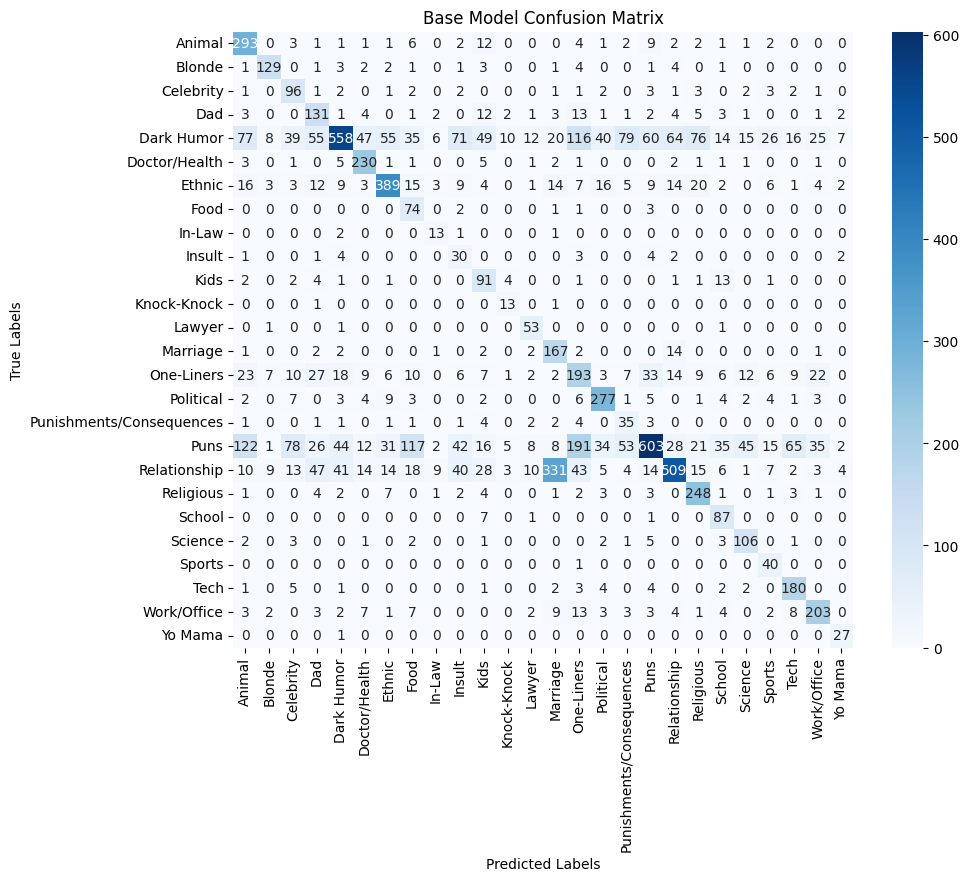

In [14]:
# Compute and plot the confusion matries individually 
cm_base = confusion_matrix(y_val, y_pred_base)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Base Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [15]:
cm_base

array([[293,   0,   3,   1,   1,   1,   1,   6,   0,   2,  12,   0,   0,
          0,   4,   1,   2,   9,   2,   2,   1,   1,   2,   0,   0,   0],
       [  1, 129,   0,   1,   3,   2,   2,   1,   0,   1,   3,   0,   0,
          1,   4,   0,   0,   1,   4,   0,   1,   0,   0,   0,   0,   0],
       [  1,   0,  96,   1,   2,   0,   1,   2,   0,   2,   0,   0,   0,
          1,   1,   2,   0,   3,   1,   3,   0,   2,   3,   2,   1,   0],
       [  3,   0,   0, 131,   1,   4,   0,   1,   2,   0,  12,   2,   1,
          3,  13,   1,   1,   2,   4,   5,   3,   1,   0,   0,   1,   2],
       [ 77,   8,  39,  55, 558,  47,  55,  35,   6,  71,  49,  10,  12,
         20, 116,  40,  79,  60,  64,  76,  14,  15,  26,  16,  25,   7],
       [  3,   0,   1,   0,   5, 230,   1,   1,   0,   0,   5,   0,   1,
          2,   1,   0,   0,   0,   2,   1,   1,   1,   0,   0,   1,   0],
       [ 16,   3,   3,  12,   9,   3, 389,  15,   3,   9,   4,   0,   1,
         14,   7,  16,   5,   9,  14,  20,   

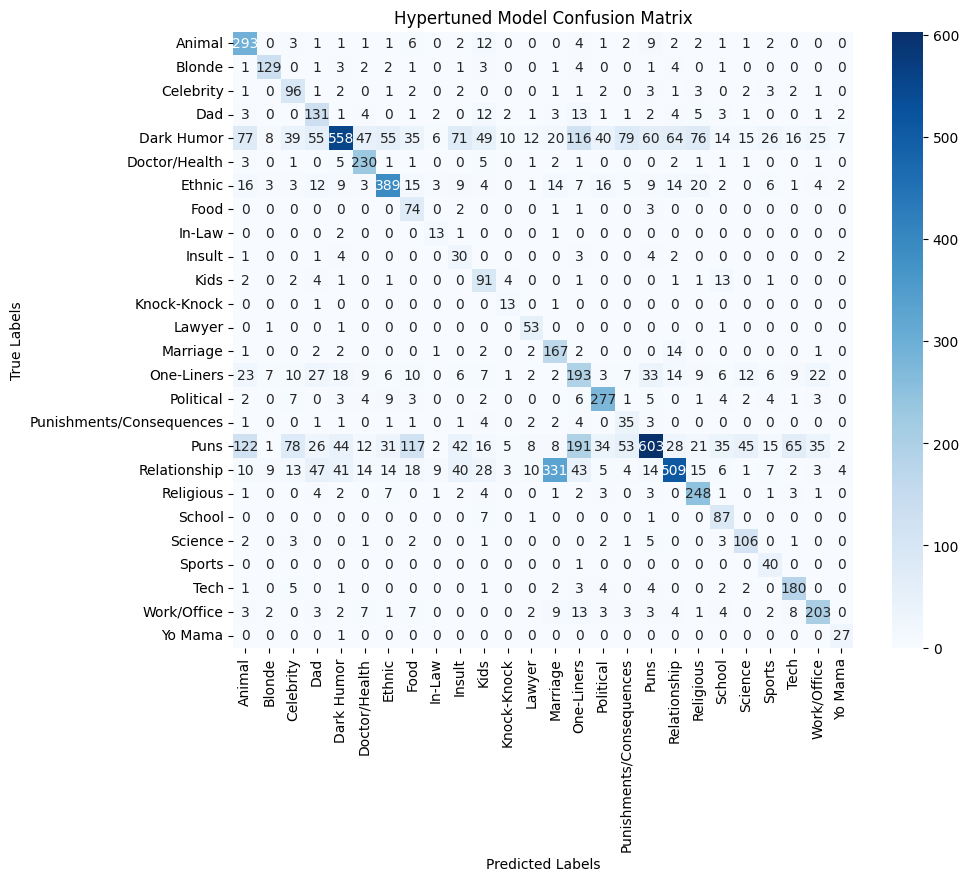

In [16]:
# Compute and plot the confusion matries individually 
cm_hypertuned = confusion_matrix(y_val, y_pred_hypertuned)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_hypertuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Hypertuned Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
cm_hypertuned


array([[293,   0,   3,   1,   1,   1,   1,   6,   0,   2,  12,   0,   0,
          0,   4,   1,   2,   9,   2,   2,   1,   1,   2,   0,   0,   0],
       [  1, 129,   0,   1,   3,   2,   2,   1,   0,   1,   3,   0,   0,
          1,   4,   0,   0,   1,   4,   0,   1,   0,   0,   0,   0,   0],
       [  1,   0,  96,   1,   2,   0,   1,   2,   0,   2,   0,   0,   0,
          1,   1,   2,   0,   3,   1,   3,   0,   2,   3,   2,   1,   0],
       [  3,   0,   0, 131,   1,   4,   0,   1,   2,   0,  12,   2,   1,
          3,  13,   1,   1,   2,   4,   5,   3,   1,   0,   0,   1,   2],
       [ 77,   8,  39,  55, 558,  47,  55,  35,   6,  71,  49,  10,  12,
         20, 116,  40,  79,  60,  64,  76,  14,  15,  26,  16,  25,   7],
       [  3,   0,   1,   0,   5, 230,   1,   1,   0,   0,   5,   0,   1,
          2,   1,   0,   0,   0,   2,   1,   1,   1,   0,   0,   1,   0],
       [ 16,   3,   3,  12,   9,   3, 389,  15,   3,   9,   4,   0,   1,
         14,   7,  16,   5,   9,  14,  20,   